# 4 Grade Diabetic Retinopathy Classification using Deep Learning

- Model: Efficient Net B0
- Dataset: Messidor
- Number of Sample points: 10800 (augmented)  | 1200 (Original)
- Number of classes: 4 (R0,R1,R2,R3)
- Loss Function: Cross Entropy loss
- Regularization: NONE 
- Learning Rate: 3e-4
- Optimizer: Adam
- Epochs: 40
- Validation: Cross Validation

Importing the required modules

In [1]:
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms,models
from torchvision.datasets import ImageFolder
from torchsummary import summary
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

This piece of code is to check whether we have GPU available in the system. 
If it prints `cuda` then one can use GPU to accelerate the training process

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #Use GPU if it's available or else use CPU.
print(device) #Prints the device we're using.

cuda


This will display the GPU device name 

In [3]:
torch.cuda.get_device_name()

'NVIDIA GeForce RTX 2080 Ti'

`ImageFolder` is a class in PyTorch that helps us to load the data as tensors. 

In [5]:
dataset = ImageFolder('../MASIDOR',transform=transforms.Compose([transforms.ToTensor(),
        transforms.Normalize([0.3080, 0.1464, 0.0501],[0.3346, 0.1610, 0.0558])]))
len(dataset),dataset.classes

(10800, ['0', '1', '2', '3'])

### To get the standard deviation and mean of the messidor dataset

In [6]:
def meanNstd(loader):
    mean = 0.0
    std = 0.0
    total_images=0
    for images,_ in tqdm(loader):
        images_per_batch = images.size(0)
        images = images.view(images_per_batch,images.size(1),-1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)

        total_images += images_per_batch

    mean /= total_images
    std /= total_images
    return mean,std



In [8]:
# meanNstd(loader)

`outDim` function calculates the ouput dimension of an image after a convolution operation. 

In [9]:
outDim = lambda i,k,p=0,s=1: (i+2*p-k)//s +1

Defining our Model

In this case we are using `Efficient Net B0`

In [6]:

model = models.efficientnet_b0(True)
model.classifier = nn.Sequential(nn.Dropout(0.5,inplace=True),
                            nn.Linear(1280,4,bias=True))


In [9]:
model.to(device)
summary(model,(3,512,512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             864
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              SiLU-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 256, 256]             288
       BatchNorm2d-5         [-1, 32, 256, 256]              64
              SiLU-6         [-1, 32, 256, 256]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 256, 256]               0
           Conv2d-13         [-1, 16, 256, 256]             512
      BatchNorm2d-14         [-1, 16, 2

Splitting the dataset into Train Set, Validation Set and Test Set.

`Train set : validation set : test set :: 70:10:20`

In [10]:
# train,val,test = torch.utils.data.random_split(dataset, [3360,480,960])
train,val,test = torch.utils.data.random_split(dataset, [7560,1080,2160])
# train,val,test = torch.utils.data.random_split(dataset, [840,120,240])
len(train), len(val), len(test)

(7560, 1080, 2160)

In [11]:
batch=16
train_dl = DataLoader(train,batch,shuffle=True,num_workers=4)
val_ds = DataLoader(val,batch,num_workers=4,shuffle = False)
test_dl = DataLoader(test,batch,num_workers=4,shuffle = False)

In [12]:
len(train_dl),len(val_ds),len(test_dl)

(473, 68, 135)

`detach()` is used to detach a tensor from the current computational graph. It returns a new tensor that doesn't require a gradient. When we don't need a tensor to be traced for the gradient computation, we detach the tensor from the current computational graph.

Defining the Train function for training

In [13]:

def train(dataloader,model,loss_fn,optimizer):
    model.train()
    total= 0 
    correct = 0
    running_loss = 0

    for (x,y) in tqdm(dataloader):
        output = model(x.to(device))
        loss = loss_fn(output,y.to(device))

        # l2_lambda = 0.01
        # # l2_norm = sum(p.pow(2).sum() for p in model.parameters())
        # # loss += (l2_lambda * l2_norm)/(batch*len(dataloader))
        # # print(output)
        # l2_reg = torch.autograd.Variable( torch.cuda.FloatTensor(1), requires_grad=True)
        # for W in model.parameters():
        #     l2_reg = l2_reg + W.norm(2)
        # loss = loss + (l2_reg * l2_lambda)/(batch*len(dataloader))
        # loss+=loss
        running_loss += loss.item()
        total += y.size(0)
        predictions = output.argmax(dim=1).cpu().detach()
        # index of the highest score for all the samples in the batch
        correct += (predictions==y.cpu().detach()).sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    acc=100*(correct/total)
    avg_loss = running_loss/len(dataloader) # average loss for a single batch
    print(f'\nTraining Loss = {avg_loss:.6f}',end='\t')
    print(f'Accuracy on Training set = {100*(correct/total):.6f}% [{correct}/{total}]') #Prints the Accuracy.
    
    return avg_loss,acc


Defining the validate function for cross validation while training

In [14]:
def validate(dataloader,model,loss_fn):

#     model in evaluation mode
    model.eval() 
    
    total = 0
    correct = 0
    running_loss = 0
    
    with torch.no_grad(): # gradients calculation not required
        
        for x,y in tqdm(dataloader):
            
            output        = model(x.to(device)) #model's output.

            loss          = loss_fn(output,y.to(device)).item() #loss calculation.
            running_loss += loss
            
            total        += y.size(0)
            predictions   = output.argmax(dim=1).cpu().detach()
            correct      += (predictions == y.cpu().detach()).sum().item()
            
    avg_loss = running_loss/len(dataloader) #Average loss per batch.      
    val_acc = 100*(correct/total)
    print(f'\nValidation Loss = {avg_loss:.6f}',end='\t')
    print(f'Accuracy on Validation set = {100*(correct/total):.6f}% [{correct}/{total}]') #Prints the Accuracy.
    
    return avg_loss,val_acc

In [15]:
def optimize(train_dataloader,valid_dataloader,model,loss_fn,optimizer,nb_epochs):
   
    train_losses = []
    valid_losses = []
    val= []
    acc=[]

    for epoch in range(nb_epochs):
        print(f'\nEpoch {epoch+1}/{nb_epochs}')
        print('-------------------------------')
        train_loss,a = train(train_dataloader,model,loss_fn,optimizer) 
        train_losses.append(train_loss)
        valid_loss,val_acc = validate(valid_dataloader,model,loss_fn)
        valid_losses.append(valid_loss)
        val.append(val_acc)
        acc.append(a)
    
    print('\nTraining has completed!')
    
    return train_losses,valid_losses,val,acc

- Loss function : Cross Entropy Loss
- Optimizer : Adam
- Epochs : 40
- Learning Rate : 0.0003

In [16]:
loss_fn   = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=3e-4) 
nb_epochs = 40
#Call the optimize function.
train_losses, valid_losses,v,acc = optimize(train_dl,val_ds,model,loss_fn,optimizer,nb_epochs)


Epoch 1/40
-------------------------------




Training Loss = 0.724026	Accuracy on Training set = 71.904762% [5436/7560]




Validation Loss = 0.481741	Accuracy on Validation set = 81.296296% [878/1080]

Epoch 2/40
-------------------------------




Training Loss = 0.443815	Accuracy on Training set = 82.989418% [6274/7560]




Validation Loss = 0.353821	Accuracy on Validation set = 87.037037% [940/1080]

Epoch 3/40
-------------------------------




Training Loss = 0.263645	Accuracy on Training set = 90.251323% [6823/7560]




Validation Loss = 0.281537	Accuracy on Validation set = 89.166667% [963/1080]

Epoch 4/40
-------------------------------




Training Loss = 0.184402	Accuracy on Training set = 93.425926% [7063/7560]




Validation Loss = 0.231274	Accuracy on Validation set = 91.296296% [986/1080]

Epoch 5/40
-------------------------------




Training Loss = 0.115007	Accuracy on Training set = 96.124339% [7267/7560]




Validation Loss = 0.278175	Accuracy on Validation set = 90.648148% [979/1080]

Epoch 6/40
-------------------------------




Training Loss = 0.111074	Accuracy on Training set = 96.084656% [7264/7560]




Validation Loss = 0.190028	Accuracy on Validation set = 93.148148% [1006/1080]

Epoch 7/40
-------------------------------




Training Loss = 0.080033	Accuracy on Training set = 97.447090% [7367/7560]




Validation Loss = 0.160202	Accuracy on Validation set = 94.259259% [1018/1080]

Epoch 8/40
-------------------------------




Training Loss = 0.064228	Accuracy on Training set = 97.804233% [7394/7560]




Validation Loss = 0.187936	Accuracy on Validation set = 93.148148% [1006/1080]

Epoch 9/40
-------------------------------




Training Loss = 0.060326	Accuracy on Training set = 97.989418% [7408/7560]




Validation Loss = 0.174061	Accuracy on Validation set = 94.907407% [1025/1080]

Epoch 10/40
-------------------------------




Training Loss = 0.063165	Accuracy on Training set = 97.830688% [7396/7560]




Validation Loss = 0.152174	Accuracy on Validation set = 95.185185% [1028/1080]

Epoch 11/40
-------------------------------




Training Loss = 0.046732	Accuracy on Training set = 98.544974% [7450/7560]




Validation Loss = 0.172785	Accuracy on Validation set = 94.444444% [1020/1080]

Epoch 12/40
-------------------------------




Training Loss = 0.047523	Accuracy on Training set = 98.465608% [7444/7560]




Validation Loss = 0.122037	Accuracy on Validation set = 95.740741% [1034/1080]

Epoch 13/40
-------------------------------




Training Loss = 0.059769	Accuracy on Training set = 97.685185% [7385/7560]




Validation Loss = 0.230216	Accuracy on Validation set = 94.166667% [1017/1080]

Epoch 14/40
-------------------------------




Training Loss = 0.050150	Accuracy on Training set = 98.253968% [7428/7560]




Validation Loss = 0.095906	Accuracy on Validation set = 96.944444% [1047/1080]

Epoch 15/40
-------------------------------




Training Loss = 0.036601	Accuracy on Training set = 98.822751% [7471/7560]




Validation Loss = 0.156777	Accuracy on Validation set = 95.462963% [1031/1080]

Epoch 16/40
-------------------------------




Training Loss = 0.039945	Accuracy on Training set = 98.716931% [7463/7560]




Validation Loss = 0.156702	Accuracy on Validation set = 94.629630% [1022/1080]

Epoch 17/40
-------------------------------




Training Loss = 0.035026	Accuracy on Training set = 98.769841% [7467/7560]




Validation Loss = 0.164756	Accuracy on Validation set = 95.000000% [1026/1080]

Epoch 18/40
-------------------------------




Training Loss = 0.070961	Accuracy on Training set = 97.711640% [7387/7560]




Validation Loss = 0.172271	Accuracy on Validation set = 94.629630% [1022/1080]

Epoch 19/40
-------------------------------




Training Loss = 0.031711	Accuracy on Training set = 98.955026% [7481/7560]




Validation Loss = 0.111482	Accuracy on Validation set = 96.111111% [1038/1080]

Epoch 20/40
-------------------------------




Training Loss = 0.022153	Accuracy on Training set = 99.179894% [7498/7560]




Validation Loss = 0.078139	Accuracy on Validation set = 97.222222% [1050/1080]

Epoch 21/40
-------------------------------




Training Loss = 0.026508	Accuracy on Training set = 99.153439% [7496/7560]




Validation Loss = 0.160207	Accuracy on Validation set = 95.370370% [1030/1080]

Epoch 22/40
-------------------------------




Training Loss = 0.038592	Accuracy on Training set = 98.756614% [7466/7560]




Validation Loss = 0.214996	Accuracy on Validation set = 94.444444% [1020/1080]

Epoch 23/40
-------------------------------




Training Loss = 0.034727	Accuracy on Training set = 98.915344% [7478/7560]




Validation Loss = 0.134189	Accuracy on Validation set = 96.296296% [1040/1080]

Epoch 24/40
-------------------------------




Training Loss = 0.020842	Accuracy on Training set = 99.272487% [7505/7560]




Validation Loss = 0.105109	Accuracy on Validation set = 96.851852% [1046/1080]

Epoch 25/40
-------------------------------




Training Loss = 0.027520	Accuracy on Training set = 98.994709% [7484/7560]




Validation Loss = 0.153301	Accuracy on Validation set = 95.555556% [1032/1080]

Epoch 26/40
-------------------------------




Training Loss = 0.034969	Accuracy on Training set = 98.915344% [7478/7560]




Validation Loss = 0.191497	Accuracy on Validation set = 95.092593% [1027/1080]

Epoch 27/40
-------------------------------




Training Loss = 0.028481	Accuracy on Training set = 99.060847% [7489/7560]




Validation Loss = 0.197085	Accuracy on Validation set = 94.722222% [1023/1080]

Epoch 28/40
-------------------------------




Training Loss = 0.034817	Accuracy on Training set = 98.915344% [7478/7560]




Validation Loss = 0.190018	Accuracy on Validation set = 95.555556% [1032/1080]

Epoch 29/40
-------------------------------




Training Loss = 0.027403	Accuracy on Training set = 99.087302% [7491/7560]




Validation Loss = 0.198929	Accuracy on Validation set = 94.629630% [1022/1080]

Epoch 30/40
-------------------------------




Training Loss = 0.031376	Accuracy on Training set = 98.981481% [7483/7560]




Validation Loss = 0.099583	Accuracy on Validation set = 96.851852% [1046/1080]

Epoch 31/40
-------------------------------




Training Loss = 0.011355	Accuracy on Training set = 99.669312% [7535/7560]




Validation Loss = 0.080750	Accuracy on Validation set = 97.129630% [1049/1080]

Epoch 32/40
-------------------------------




Training Loss = 0.018887	Accuracy on Training set = 99.298942% [7507/7560]




Validation Loss = 0.181828	Accuracy on Validation set = 95.370370% [1030/1080]

Epoch 33/40
-------------------------------




Training Loss = 0.024789	Accuracy on Training set = 99.087302% [7491/7560]




Validation Loss = 0.101304	Accuracy on Validation set = 96.851852% [1046/1080]

Epoch 34/40
-------------------------------




Training Loss = 0.020467	Accuracy on Training set = 99.219577% [7501/7560]




Validation Loss = 0.207982	Accuracy on Validation set = 94.537037% [1021/1080]

Epoch 35/40
-------------------------------




Training Loss = 0.024908	Accuracy on Training set = 99.206349% [7500/7560]




Validation Loss = 0.097691	Accuracy on Validation set = 97.222222% [1050/1080]

Epoch 36/40
-------------------------------




Training Loss = 0.023450	Accuracy on Training set = 99.113757% [7493/7560]




Validation Loss = 0.170553	Accuracy on Validation set = 95.555556% [1032/1080]

Epoch 37/40
-------------------------------




Training Loss = 0.027980	Accuracy on Training set = 99.140212% [7495/7560]




Validation Loss = 0.120890	Accuracy on Validation set = 96.481481% [1042/1080]

Epoch 38/40
-------------------------------




Training Loss = 0.010393	Accuracy on Training set = 99.616402% [7531/7560]




Validation Loss = 0.118799	Accuracy on Validation set = 97.037037% [1048/1080]

Epoch 39/40
-------------------------------




Training Loss = 0.038057	Accuracy on Training set = 98.637566% [7457/7560]




Validation Loss = 0.116923	Accuracy on Validation set = 96.574074% [1043/1080]

Epoch 40/40
-------------------------------




Training Loss = 0.024360	Accuracy on Training set = 99.166667% [7497/7560]




Validation Loss = 0.104411	Accuracy on Validation set = 97.129630% [1049/1080]

Training has completed!


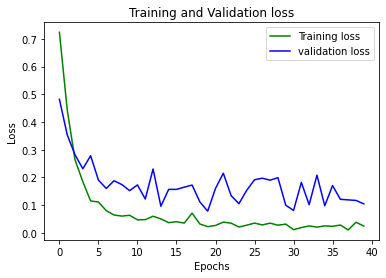

In [17]:

epochs = range(nb_epochs)
plt.plot(epochs, train_losses, 'g', label='Training loss')
plt.plot(epochs, valid_losses, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

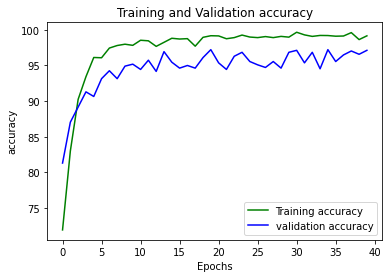

In [18]:
epochs = range(nb_epochs)
plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, v, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [19]:
def Final_test(dataloader,model,loss_fn):

#     model in evaluation mode
    model.eval() 
    
    total = 0
    correct = 0
    running_loss = 0
    
    with torch.no_grad(): # gradients calculation not required
        
        for x,y in dataloader:
            
            output        = model(x.to(device)) #model's output.
            loss          = loss_fn(output,y.to(device)).item() #loss calculation.
            running_loss += loss
            
            total        += y.size(0)
            predictions   = output.argmax(dim=1).cpu().detach()
            correct      += (predictions == y.cpu().detach()).sum().item()
            
    avg_loss = running_loss/len(dataloader) #Average loss per batch.      
    val_acc = 100*(correct/total)
    print(f'\t test Loss = {avg_loss:.6f}',end='\t')
    print(f'Accuracy on test set = {100*(correct/total):.6f}% [{correct}/{total}]') #Prints the Accuracy.
    
    print('avg_loss',avg_loss,'val_acc',val_acc)

Results on the training set

In [20]:
Final_test(test_dl,model,loss_fn)

	 test Loss = 0.093076	Accuracy on test set = 97.129630% [2098/2160]
avg_loss 0.0930759628438089 val_acc 97.12962962962963


In [21]:
torch.save(model.state_dict(),'model97.pth')

In [25]:
print('Training loss', train_losses)

Training loss [0.8206656123910632, 0.5359767151730401, 0.3801248095574833, 0.2510096306247371, 0.16214840447618847, 0.13046579987165474, 0.09516770305067655, 0.09083731100739291, 0.08069979549618438, 0.06507589918439322, 0.061618831653946216, 0.05508113978929552, 0.06531800295204102, 0.08268967179825441, 0.05362055943170119, 0.03988151844019913, 0.022268424744834193, 0.03524329835587802, 0.02904763664624798, 0.06360849395859987, 0.0574200737629629, 0.03318334873807284, 0.022579623032652308, 0.026163027050400463, 0.08120426111459632, 0.05491288451455711, 0.024112165988411843, 0.020018445626867887, 0.016502380052683986, 0.022046545794070144, 0.03529737195720026, 0.03105917412127989, 0.04759163006584415, 0.05097939846676863, 0.04051571596951579, 0.0345628491832204, 0.024183246800748747, 0.015856705060650712, 0.04257004580000025, 0.025679598387432633]


In [26]:
print('Validation loss', valid_losses)

Validation loss [0.5355992799003919, 0.5146637062231699, 0.5775555188457171, 0.28671096165974935, 0.4321647067864736, 0.2735836804844439, 0.2411770788797488, 0.26524061520273484, 0.29903727599109214, 0.3033341327061256, 0.3504817737111201, 0.3525968935961525, 0.37551649327700337, 0.2691271284750352, 0.2850798886579772, 0.2620852242146308, 0.3215768687116603, 0.35241423491388557, 0.31343956390434563, 0.3919985508235792, 0.2434051767612497, 0.26324635843435923, 0.36063821030159793, 0.2669898871468225, 0.49074126152166475, 0.3545550266086745, 0.29653440877639997, 0.3249491925816983, 0.4220108341619683, 0.3292855474166572, 0.3565324805987378, 0.3917264812849074, 0.7657338507395859, 0.3473130943253636, 0.30922079626470805, 0.22709954142725716, 0.9070007290691138, 0.19851580566416185, 0.3025913056354815, 0.2871346710405002]


In [27]:
print('training accuracy',acc)
print('validation accuracy',v)

training accuracy [67.41071428571429, 79.76190476190477, 86.01190476190477, 91.04166666666667, 94.13690476190476, 95.32738095238096, 96.57738095238095, 96.9047619047619, 97.20238095238095, 97.58928571428571, 97.85714285714285, 98.21428571428571, 97.67857142857143, 97.02380952380952, 98.21428571428571, 98.66071428571429, 99.19642857142857, 98.75, 99.16666666666667, 97.94642857142857, 98.125, 98.83928571428572, 99.22619047619048, 99.10714285714286, 96.9047619047619, 98.1547619047619, 99.07738095238095, 99.43452380952381, 99.52380952380952, 99.13690476190476, 98.77976190476191, 98.89880952380953, 98.51190476190477, 98.39285714285714, 98.66071428571429, 98.83928571428572, 99.10714285714286, 99.52380952380952, 98.77976190476191, 99.13690476190476]
validation accuracy [77.29166666666667, 78.54166666666667, 78.75, 88.54166666666666, 83.95833333333333, 92.08333333333333, 93.33333333333333, 90.625, 90.41666666666667, 91.25, 90.0, 92.29166666666667, 88.54166666666666, 90.83333333333333, 90.83333

In [28]:
len(acc),len(v),len(train_losses),len(valid_losses)

(40, 40, 40, 40)

In [30]:
torch.save(model.state_dict,'model.pth')